In [1]:
#sen1flood11数据的均值和方差
nor=[
    [1612.2641794179053,694.6404158569574],
    [1379.8899556061613,734.589213934987],
    [1344.4295633683826,731.6118897277566],
    [1195.157229000143,860.603745394514],
    [1439.168369746529,771.3569863637912],
    [2344.2498120705645,921.6300590130161],
    [2796.473722876989,1088.0256714514674],
    [2578.4108992777597,1029.246558060433],
    [3023.817505678254,1205.1064480965915],
    [476.7287418382585,331.6878880293502],
    [59.24111403905757,130.40242222578226],
    [1989.1945548720423,993.7071664926801],
    [1152.4886461779677, 768.8907975412457],
    [-0.2938129263276281,0.21578320121968173],
    [-0.36928344017880277,0.19538602918264955],
    [-6393.00646782349,0.19538602918264955],
    [-2398.566478742078,0.19538602918264955]
    
]

In [2]:
# !pip install rasterio

# !sudo mkdir checkpoints
# from google.colab import drive 
# drive.mount('/content/drive/')
# %cd ./drive/MyDrive/vgg


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 2.1 MB/s 


In [3]:
from osgeo import gdal
import torch
from torchvision import transforms
import torchvision.transforms.functional as F
import torchvision.models as models
import torch.nn as nn

import numpy as np
import random
from PIL import Image
from time import time
import csv
import os
import numpy as np
import rasterio

from tqdm.notebook import tqdm
from IPython.display import clear_output

import os
from IPython.display import display
import matplotlib.pyplot as plt

In [ ]:
path='./dataset/v1.1/data/flood_events/HandLabeled/'  #修改
model_save_path='./checkpoints/'  #修改
S2_path = path+'S2Hand/'
Labels_path = path+'LabelHand/'
csv_path = './dataset/HandLabelS2_csv/'

In [ ]:
# !gsutil cp gs://sen1floods11/v1.1/splits/flood_handlabeled/flood_train_data.csv .
# !gsutil cp gs://sen1floods11/v1.1/splits/flood_handlabeled/flood_test_data.csv .
# !gsutil cp gs://sen1floods11/v1.1/splits/flood_handlabeled/flood_valid_data.csv .

In [ ]:
# !sudo mkdir files
# !sudo mkdir files/S1
# !sudo mkdir files/Labels
# # 意思是把标注数据下载到对应文件夹，s1也到对应文件夹
# !gsutil -m rsync -r gs://sen1floods11/v1.1/data/flood_events/HandLabeled/S1Hand files/S1
# !gsutil -m rsync -r gs://sen1floods11/v1.1/data/flood_events/HandLabeled/LabelHand files/Labels

# !sudo mkdir files/S2
# !gsutil -m rsync -r gs://sen1floods11/v1.1/data/flood_events/HandLabeled/S2Hand files/S2

In [16]:
# 小脚本
import os
filePath = S2_path
s2list=sorted(os.listdir(filePath))
print(s2list)
filePath = Labels_path
labellist=sorted(os.listdir(filePath))
print(labellist)

paired_list=[]
for i in range(len(s2list)):
  paired_list.append([s2list[i], labellist[i]])
print(paired_list)

import pandas as pd
train_data = paired_list[0:int(0.6*len(s2list))]
valid_data = paired_list[int(0.6*len(s2list)):int(0.8*len(s2list))]
test_data = paired_list[int(0.8*len(s2list)):]
train=pd.DataFrame(data=train_data)
train.to_csv(csv_path+'flood_s2_train_data.csv')
valid=pd.DataFrame(data=valid_data)
valid.to_csv(csv_path+'flood_s2_valid_data.csv')
test=pd.DataFrame(data=test_data)
test.to_csv(csv_path+'/flood_s2_test_data.csv')

['Bolivia_103757_S2Hand.tif', 'Bolivia_129334_S2Hand.tif', 'Bolivia_195474_S2Hand.tif', 'Bolivia_23014_S2Hand.tif', 'Bolivia_233925_S2Hand.tif', 'Bolivia_242570_S2Hand.tif', 'Bolivia_290290_S2Hand.tif', 'Bolivia_294583_S2Hand.tif', 'Bolivia_312675_S2Hand.tif', 'Bolivia_314919_S2Hand.tif', 'Bolivia_360519_S2Hand.tif', 'Bolivia_379434_S2Hand.tif', 'Bolivia_432776_S2Hand.tif', 'Bolivia_60373_S2Hand.tif', 'Bolivia_76104_S2Hand.tif', 'Ghana_103272_S2Hand.tif', 'Ghana_1033830_S2Hand.tif', 'Ghana_1078550_S2Hand.tif', 'Ghana_1089161_S2Hand.tif', 'Ghana_11745_S2Hand.tif', 'Ghana_124834_S2Hand.tif', 'Ghana_128663_S2Hand.tif', 'Ghana_132163_S2Hand.tif', 'Ghana_134751_S2Hand.tif', 'Ghana_135389_S2Hand.tif', 'Ghana_141271_S2Hand.tif', 'Ghana_141910_S2Hand.tif', 'Ghana_142312_S2Hand.tif', 'Ghana_144050_S2Hand.tif', 'Ghana_146222_S2Hand.tif', 'Ghana_147015_S2Hand.tif', 'Ghana_154838_S2Hand.tif', 'Ghana_156478_S2Hand.tif', 'Ghana_161233_S2Hand.tif', 'Ghana_167233_S2Hand.tif', 'Ghana_168875_S2Hand.tif'

In [6]:
LR = 5e-4

CHANNEL=3  #参与训练的波段数，修改
RUNNAME = "default"
outputnumber=3

In [7]:
class InMemoryDataset(torch.utils.data.Dataset):
  
  def __init__(self, data_list, preprocess_func):
    self.data_list = data_list
    self.preprocess_func = preprocess_func
  
  def __getitem__(self, i):
    return self.preprocess_func(self.data_list[i])
  
  def __len__(self):
    return len(self.data_list)

def processAndAugment(data):
  (sen2, y) = data
  s2,label = sen2.copy(),y.copy()

  # convert to PIL for easier transforms

  band1 = Image.fromarray(s2[0])

  band2 = Image.fromarray(s2[1])
    # print(band2.mean())
  band3 = Image.fromarray(s2[2])
  band4 = Image.fromarray(s2[3])
  band5 = Image.fromarray(s2[4])
  band6 = Image.fromarray(s2[5])
  band7 = Image.fromarray(s2[6])
  band8 = Image.fromarray(s2[7])
    # print(band8.mean())
  band8A = Image.fromarray(s2[8])
  band9 = Image.fromarray(s2[9])
    # print(band10.mean())
  band10 = Image.fromarray(s2[10])
  band11 = Image.fromarray(s2[11])
    # print(band12.mean())
  band12 = Image.fromarray(s2[12])


  label = Image.fromarray(label.squeeze())

  # Get params for random transforms
  i, j, h, w = transforms.RandomCrop.get_params(band1, (256, 256))
  

  band1 = F.crop(band1, i, j, h, w)
  band2 = F.crop(band2, i, j, h, w)
  band3 = F.crop(band3, i, j, h, w)
  band4 = F.crop(band4, i, j, h, w)
  band5 = F.crop(band5, i, j, h, w)
  band6 = F.crop(band6, i, j, h, w)
  band7 = F.crop(band7, i, j, h, w)
  band8 = F.crop(band8, i, j, h, w)
  band8A = F.crop(band8A, i, j, h, w)
  band9 = F.crop(band9, i, j, h, w)
  band10 = F.crop(band10, i, j, h, w)
  band11 = F.crop(band11, i, j, h, w)
  band12 = F.crop(band12, i, j, h, w)
  

  label = F.crop(label, i, j, h, w)
  if random.random() > 0.5:
    band1 = F.hflip(band1)
    band2 = F.hflip(band2)
    band3 = F.hflip(band3)
    band4 = F.hflip(band4)
    band5 = F.hflip(band5)
    band6 = F.hflip(band6)
    band7 = F.hflip(band7)
    band8 = F.hflip(band8)
    band8A = F.hflip(band8A)
    band9 = F.hflip(band9)
    # print(band10.mean())
    band10 = F.hflip(band10)
    band11 = F.hflip(band11)
    band12 = F.hflip(band12)

    label = F.hflip(label)

  if random.random() > 0.5:
    
    band1 = F.vflip(band1)
    band2 = F.vflip(band2)
    band3 = F.vflip(band3)
    band4 = F.vflip(band4)
    band5 = F.vflip(band5)
    band6 = F.vflip(band6)
    band7 = F.vflip(band7)
    band8 = F.vflip(band8)
    band8A = F.vflip(band8A)
    band9 = F.vflip(band9)
    # print(band10.mean())
    band10 = F.vflip(band10)
    band11 = F.vflip(band11)
    band12 = F.vflip(band12)

    label = F.vflip(label)


  band1_ = transforms.ToTensor()(band1).squeeze().float()
  band2_ = transforms.ToTensor()(band2).squeeze().float()
  band3_ = transforms.ToTensor()(band3).squeeze().float()
  band4_ = transforms.ToTensor()(band4).squeeze().float()
  band5_ = transforms.ToTensor()(band5).squeeze().float()
  band6_ = transforms.ToTensor()(band6).squeeze().float()
  band7_ = transforms.ToTensor()(band7).squeeze().float()
  band8_ = transforms.ToTensor()(band8).squeeze().float()
  band8A_ = transforms.ToTensor()(band8A).squeeze().float()
  band9_ = transforms.ToTensor()(band9).squeeze().float()
  band10_ =transforms.ToTensor()(band10).squeeze().float()
  band11_ = transforms.ToTensor()(band11).squeeze().float()
  band12_ = transforms.ToTensor()(band12).squeeze().float()

  # norm = transforms.Normalize([nor[6][0],
  #        nor[7][0],
  #        nor[8][0],
  #        nor[11][0],
  #        nor[12][0]],[nor[6][1],
  #        nor[7][1],
  #        nor[8][1],
  #        nor[11][1],
  #        nor[12][1]])
  norm = transforms.Normalize([nor[4][0], nor[3][0], nor[2][0]],
                              [nor[4][1], nor[3][1], nor[2][1]]
                              )
  
  # ims = torch.stack([band7_,band8_,band8A_,band11_,band12_])
  ims = torch.stack([band4_,band3_,band2_])
  ims = norm(ims)

  label = transforms.ToTensor()(label).squeeze()
  if torch.sum(label.gt(.003) * label.lt(.004)):
    label *= 255.0
  label=label/1.0
  label = label.round()
  
  return ims, label


def processTestIm(data):
  (sen2, y) = data
  s2, label = sen2.copy(), y.copy()

  # norm = transforms.Normalize([nor[6][0],
  #        nor[7][0],
  #        nor[8][0],
  #        nor[11][0],
  #        nor[12][0]],[nor[6][1],
  #        nor[7][1],
  #        nor[8][1],
  #        nor[11][1],
  #        nor[12][1]])
  norm = transforms.Normalize([nor[4][0], nor[3][0], nor[2][0]],
                              [nor[4][1], nor[3][1], nor[2][1]]
                              )

  # convert to PIL for easier transforms

  band1 = Image.fromarray(s2[0]).resize((512,512))

  band2 = Image.fromarray(s2[1]).resize((512,512))
  # print(band2.mean())
  band3 = Image.fromarray(s2[2]).resize((512,512))
  band4 = Image.fromarray(s2[3]).resize((512,512))
  band5 = Image.fromarray(s2[4]).resize((512,512))
  band6 = Image.fromarray(s2[5]).resize((512,512))
  band7 = Image.fromarray(s2[6]).resize((512,512))
  band8 = Image.fromarray(s2[7]).resize((512,512))
  # print(band8.mean())
  band8A = Image.fromarray(s2[8]).resize((512,512))
  band9 = Image.fromarray(s2[9]).resize((512,512))
  # print(band10.mean())
  band10 = Image.fromarray(s2[10]).resize((512,512))
  band11 = Image.fromarray(s2[11]).resize((512,512))
  # print(band12.mean())
  band12 = Image.fromarray(s2[12]).resize((512,512))

  
  label = Image.fromarray(label.squeeze()).resize((512,512))


  band1s = [F.crop(band1, 0, 0, 256, 256), F.crop(band1, 0, 256, 256, 256),
              F.crop(band1, 256, 0, 256, 256), F.crop(band1, 256, 256, 256, 256)]
  band2s = [F.crop(band2, 0, 0, 256, 256), F.crop(band2, 0, 256, 256, 256),
              F.crop(band2, 256, 0, 256, 256), F.crop(band2, 256, 256, 256, 256)]
  band3s = [F.crop(band3, 0, 0, 256, 256), F.crop(band3, 0, 256, 256, 256),
              F.crop(band3, 256, 0, 256, 256), F.crop(band3, 256, 256, 256, 256)]
  band4s = [F.crop(band4, 0, 0, 256, 256), F.crop(band4, 0, 256, 256, 256),
              F.crop(band4, 256, 0, 256, 256), F.crop(band4, 256, 256, 256, 256)]
  band5s = [F.crop(band5, 0, 0, 256, 256), F.crop(band5, 0, 256, 256, 256),
              F.crop(band5, 256, 0, 256, 256), F.crop(band5, 256, 256, 256, 256)]
  band6s = [F.crop(band6, 0, 0, 256, 256), F.crop(band6, 0, 256, 256, 256),
              F.crop(band6, 256, 0, 256, 256), F.crop(band6, 256, 256, 256, 256)]
  band7s = [F.crop(band7, 0, 0, 256, 256), F.crop(band7, 0, 256, 256, 256),
              F.crop(band7, 256, 0, 256, 256), F.crop(band7, 256, 256, 256, 256)]
  band8s = [F.crop(band8, 0, 0, 256, 256), F.crop(band8, 0, 256, 256, 256),
              F.crop(band8, 256, 0, 256, 256), F.crop(band8, 256, 256, 256, 256)]
  band9s = [F.crop(band9, 0, 0, 256, 256), F.crop(band9, 0, 256, 256, 256),
              F.crop(band9, 256, 0, 256, 256), F.crop(band9, 256, 256, 256, 256)]
  band10s = [F.crop(band10, 0, 0, 256, 256), F.crop(band10, 0, 256, 256, 256),
              F.crop(band10, 256, 0, 256, 256), F.crop(band10, 256, 256, 256, 256)]
  band11s = [F.crop(band11, 0, 0, 256, 256), F.crop(band11, 0, 256, 256, 256),
              F.crop(band11, 256, 0, 256, 256), F.crop(band11, 256, 256, 256, 256)]
  band12s = [F.crop(band12, 0, 0, 256, 256), F.crop(band12, 0, 256, 256, 256),
              F.crop(band12, 256, 0, 256, 256), F.crop(band12, 256, 256, 256, 256)]
  band8As = [F.crop(band8A, 0, 0, 256, 256), F.crop(band8A, 0, 256, 256, 256),
              F.crop(band8A, 256, 0, 256, 256), F.crop(band8A, 256, 256, 256, 256)]
 
  labels = [F.crop(label, 0, 0, 256, 256), F.crop(label, 0, 256, 256, 256),
            F.crop(label, 256, 0, 256, 256), F.crop(label, 256, 256, 256, 256)]


  # ims = [torch.stack((transforms.ToTensor()(x1).squeeze().float(),
  #                   transforms.ToTensor()(x2).squeeze().float(),
  #                   transforms.ToTensor()(x3).squeeze().float(),
  #                   transforms.ToTensor()(x4).squeeze().float(),
  #                   transforms.ToTensor()(x5).squeeze().float()))
  #                   for (x1,x2,x3,x4,x5,) in zip(band7s,band8s,band8As,band11s,band12s)]
  
  ims = [torch.stack((transforms.ToTensor()(x1).squeeze().float(),
                    transforms.ToTensor()(x2).squeeze().float(),
                    transforms.ToTensor()(x3).squeeze().float()))
                    for (x1,x2,x3,) in zip(band4s,band3s,band2s)]
  
  ims = [norm(im) for im in ims]
  ims = torch.stack(ims)
  
  labels = [(transforms.ToTensor()(label).squeeze()) for label in labels]
  labels = torch.stack(labels)
  # print(labels)
  
  if torch.sum(labels.gt(.003) * labels.lt(.004)):
    labels *= 255
  labels=labels/1.0
  labels = labels.round()
  
  return ims, labels

In [8]:
def getArrFlood(fname):
  return rasterio.open(fname).read()


def download_flood_water_data_from_list(l):
  i = 0
  tot_nan = 0
  tot_good = 0
  flood_data = []
  for (s2_fname, mask_fname) in l:

    if not os.path.exists(s2_fname):
      print("warning")
      continue
    
    arr_s2 = np.nan_to_num(getArrFlood(s2_fname))
  
    arr_y = getArrFlood(mask_fname)
    arr_y[arr_y == -1] = 255


    if i % 100 == 0:
      print(s2_fname, mask_fname)
    i += 1
    flood_data.append((arr_s2, arr_y))

  return flood_data


def load_flood_train_data(path):
  input_root_s2 = S2_path
  label_root = Labels_path
  fname = csv_path+"flood_s2_train_data.csv"
  training_files = []
  with open(fname) as f:
    for line in csv.reader(f):
      training_files.append(tuple((input_root_s2+line[1], label_root+line[2])))
      
      #print(input_root_s1+line[0])
  # print(training_files)
  return download_flood_water_data_from_list(training_files)

def load_flood_valid_data(path):
  
  input_root_s2 = S2_path
  label_root = Labels_path
  fname = csv_path+"flood_s2_valid_data.csv"
  
  validation_files = []
  with open(fname) as f:
    for line in csv.reader(f):
      validation_files.append(tuple((input_root_s2+line[1], label_root+line[2])))

  return download_flood_water_data_from_list(validation_files)


In [17]:
train_data = load_flood_train_data(path)
train_dataset = InMemoryDataset(train_data, processAndAugment)

valid_data = load_flood_valid_data(path) 
valid_dataset = InMemoryDataset(valid_data, processTestIm)

[('/content/drive/MyDrive/vgg/files/S2/0', '/content/drive/MyDrive/vgg/files/Labels/1'), ('/content/drive/MyDrive/vgg/files/S2/Bolivia_103757_S2Hand.tif', '/content/drive/MyDrive/vgg/files/Labels/Bolivia_103757_LabelHand.tif'), ('/content/drive/MyDrive/vgg/files/S2/Bolivia_129334_S2Hand.tif', '/content/drive/MyDrive/vgg/files/Labels/Bolivia_129334_LabelHand.tif'), ('/content/drive/MyDrive/vgg/files/S2/Bolivia_195474_S2Hand.tif', '/content/drive/MyDrive/vgg/files/Labels/Bolivia_195474_LabelHand.tif'), ('/content/drive/MyDrive/vgg/files/S2/Bolivia_23014_S2Hand.tif', '/content/drive/MyDrive/vgg/files/Labels/Bolivia_23014_LabelHand.tif'), ('/content/drive/MyDrive/vgg/files/S2/Bolivia_233925_S2Hand.tif', '/content/drive/MyDrive/vgg/files/Labels/Bolivia_233925_LabelHand.tif'), ('/content/drive/MyDrive/vgg/files/S2/Bolivia_242570_S2Hand.tif', '/content/drive/MyDrive/vgg/files/Labels/Bolivia_242570_LabelHand.tif'), ('/content/drive/MyDrive/vgg/files/S2/Bolivia_290290_S2Hand.tif', '/content/dri

In [19]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=False, sampler=None,
                  batch_sampler=None, num_workers=0, collate_fn=None,
                  pin_memory=True, drop_last=False, timeout=0,
                  worker_init_fn=None)
train_iter = iter(train_loader)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=2, shuffle=False, sampler=None,
                  batch_sampler=None, num_workers=0, collate_fn=lambda x: (torch.cat([a[0] for a in x], 0), torch.cat([a[1] for a in x], 0)),
                  pin_memory=True, drop_last=False, timeout=0,
                  worker_init_fn=None)
valid_iter = iter(valid_loader)


In [20]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out

class NestedUNet(nn.Module):
    def __init__(self, num_classes, input_channels=3, deep_supervision=False, **kwargs):
        super().__init__()

        nb_filter = [32, 64, 128, 256, 512,1024]

        self.deep_supervision = deep_supervision

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])
        

        self.conv0_1 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_1 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_1 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])
        

        self.conv0_2 = VGGBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_2 = VGGBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_2 = VGGBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])
        

        self.conv0_3 = VGGBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_3 = VGGBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])
        

        self.conv0_4 = VGGBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])
        

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)


    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

      
        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            
            if outputnumber==0:
              return output1
            elif outputnumber==1:
              return output2
            elif outputnumber==2:
              return output3
            elif outputnumber==3:
              return output4
        else:
            output = self.final(x0_4)
            return output

In [21]:
net = NestedUNet(num_classes=2,input_channels=CHANNEL,deep_supervision=True)

net = net.cuda()
torch.cuda.empty_cache()

In [23]:
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1,8]).float().cuda(), ignore_index=255) 
optimizer = torch.optim.AdamW(net.parameters(),lr=LR)
print(len(train_loader) * 10)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, len(train_loader) * 10, T_mult=2, eta_min=0, last_epoch=-1)

def convertBNtoGN(module, num_groups=16):
  if isinstance(module, torch.nn.modules.batchnorm.BatchNorm2d):
    return nn.GroupNorm(num_groups, module.num_features,
                        eps=module.eps, affine=module.affine)
    if module.affine:
        mod.weight.data = module.weight.data.clone().detach()
        mod.bias.data = module.bias.data.clone().detach()

  for name, child in module.named_children():
      module.add_module(name, convertBNtoGN(child, num_groups=num_groups))

  return module

net = convertBNtoGN(net)

1340


In [24]:
def computeIOU(output, target):
  output = torch.argmax(output, dim=1).flatten() 
  target = target.flatten()
  
  no_ignore = target.ne(255).cuda()
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  intersection = torch.sum(output * target)
  union = torch.sum(target) + torch.sum(output) - intersection
  iou = (intersection + .0000001) / (union + .0000001)
  
  if iou != iou:
    print("failed, replacing with 0")
    iou = torch.tensor(0).float()
  
  return iou
  
def computeAccuracy(output, target):
  output = torch.argmax(output, dim=1).flatten() 
  target = target.flatten()
  
  no_ignore = target.ne(255).cuda()
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  correct = torch.sum(output.eq(target))
  
  return correct.float() / len(target)

In [25]:
max_valid_iou = 0
start = 0
epochs = []
training_losses = []
training_accuracies = []
training_ious = []
valid_losses = []
valid_accuracies = []
valid_ious = []

running_loss = 0
running_iou = 0
running_count = 0
running_accuracy = 0

In [26]:
def train_loop(inputs, labels, net, optimizer, scheduler):
  global running_loss
  global running_iou
  global running_count
  global running_accuracy
  
  # zero the parameter gradients
  optimizer.zero_grad()
  net = net.cuda()
  
  # forward + backward + optimize
  outputs = net(inputs.cuda())
  loss = criterion(outputs, labels.long().cuda())
  loss.backward()
  optimizer.step()
  scheduler.step()

  running_loss += loss
  running_iou += computeIOU(outputs, labels.cuda())
  running_accuracy += computeAccuracy(outputs, labels.cuda())
  running_count += 1

In [27]:
def validation_loop(model_save_path,validation_data_loader, net,cur_epoch):
  global running_loss
  global running_iou
  global running_count
  global running_accuracy
  global max_valid_iou

  global training_losses
  global training_accuracies
  global training_ious
  global valid_losses
  global valid_accuracies
  global valid_ious

  global model_path

  net = net.eval()
  net = net.cuda()
  count = 0
  iou = 0
  loss = 0
  accuracy = 0
  with torch.no_grad():
      for (images, labels) in validation_data_loader:
          net = net.cuda()
          outputs = net(images.cuda())
          valid_loss = criterion(outputs, labels.long().cuda())
          valid_iou = computeIOU(outputs, labels.cuda())
          valid_accuracy = computeAccuracy(outputs, labels.cuda())
          iou += valid_iou
          loss += valid_loss
          accuracy += valid_accuracy
          count += 1

          

  iou = iou / count
  accuracy = accuracy / count

  if iou > max_valid_iou:
    max_valid_iou = iou
    model_path = os.path.join(model_save_path, "{}_{}_{}_{:.6f}.cp".format(RUNNAME,outputnumber,cur_epoch, iou.item()))
    
    torch.save(net, model_path)
    print("model saved at", model_path)

  loss = loss / count
  print("Training Loss:", running_loss / running_count)
  print("Training IOU:", running_iou / running_count)
  print("Training Accuracy:", running_accuracy / running_count)
  print("Validation Loss:", loss)
  print("Validation IOU:", iou)
  print("Validation Accuracy:", accuracy)

  training_losses.append((running_loss / running_count).cpu().detach())
  training_accuracies.append((running_accuracy / running_count).cpu().detach())
  training_ious.append((running_iou / running_count).cpu().detach())
  valid_losses.append(loss.cpu().detach())
  valid_accuracies.append(accuracy.cpu().detach())
  valid_ious.append(iou.cpu().detach())

In [28]:
def train_epoch(net, optimizer, scheduler, train_iter):
  for (inputs, labels) in tqdm(train_iter):
    train_loop(inputs.cuda(), labels.cuda(), net.cuda(), optimizer, scheduler)
 

def train_validation_loop(model_save_path,net, optimizer, scheduler, train_loader,
                          valid_loader, num_epochs, cur_epoch):
  global running_loss
  global running_iou
  global running_count
  global running_accuracy
  net = net.train()
  running_loss = 0
  running_iou = 0
  running_count = 0
  running_accuracy = 0
  
  for i in tqdm(range(num_epochs)):
    train_iter = iter(train_loader)
    train_epoch(net, optimizer, scheduler, train_iter)
  clear_output()
  
  print("Current Epoch:", cur_epoch)
  validation_loop(model_save_path,iter(valid_loader), net,cur_epoch)

Current Epoch: 4
model saved at /content/drive/MyDrive/vgg/checkpoints/Perus_part_s2_3_4_0.47675830125808716.cp
Training Loss: tensor(0.1577, device='cuda:0', grad_fn=<DivBackward0>)
Training IOU: tensor(0.4777, device='cuda:0')
Training Accuracy: tensor(0.9354, device='cuda:0')
Validation Loss: tensor(0.1748, device='cuda:0')
Validation IOU: tensor(0.4768, device='cuda:0')
Validation Accuracy: tensor(0.9515, device='cuda:0')


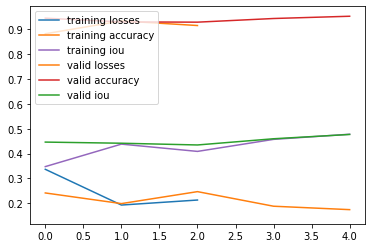

None

max valid iou: tensor(0.4768, device='cuda:0')


In [29]:
iscontinue=True
if iscontinue==False:
  max_valid_iou = 0
  start = 0
  epochs = []
  training_losses = []
  training_accuracies = []
  training_ious = []
  valid_losses = []
  valid_accuracies = []
  valid_ious = []
else :
  print('restart')

for i in range(start, 5):
  
  train_validation_loop(model_save_path,net, optimizer, scheduler, train_loader, valid_loader, 5, i)
  epochs.append(i)
  x = epochs
  
  plt.figure ()
  plt.plot(x, training_losses, label='training losses')
  plt.plot(x, training_accuracies, 'tab:orange', label='training accuracy')
  plt.plot(x, training_ious, 'tab:purple', label='training iou')
  plt.plot(x, valid_losses, label='valid losses')
  plt.plot(x, valid_accuracies, 'tab:red',label='valid accuracy')
  plt.plot(x, valid_ious, 'tab:green',label='valid iou')
  plt.legend(loc="upper left")

  # display(plt.show())
  plt.savefig('./img/'+RUNNAME+'{}.png'.format(i))

  print("max valid iou:", max_valid_iou)

**test**


In [13]:
def download_flood_test_data_from_list(l):
  i = 0
  tot_nan = 0
  tot_good = 0
  flood_data = []
  for (s2_fname, mask_fname) in l:
    # print(s1_fname)

    if not os.path.exists(s2_fname):
      print("warning")
      continue
    
    arr_s2 = np.nan_to_num(getArrFlood(s2_fname))
  
    arr_y = getArrFlood(mask_fname)
    arr_y[arr_y == -1] = 255


    if i % 100 == 0:
      print(s2_fname, mask_fname)
    i += 1
    flood_data.append((arr_s2, arr_y))

  return flood_data
 

def load_flood_test_data(path):
  input_root_s2 = S2_path
  label_root = Labels_path
  fname = csv_path+"flood_s2_test_data.csv"
  training_files = []
  with open(fname) as f:
    for line in csv.reader(f):
      training_files.append(tuple((input_root_s2+line[1], label_root+line[2])))


  return download_flood_test_data_from_list(training_files)

In [34]:
test_data = load_flood_test_data(path)
print(len(test_data))

warning
/content/drive/MyDrive/vgg/files/S2/Sri-Lanka_52223_S2Hand.tif /content/drive/MyDrive/vgg/files/Labels/Sri-Lanka_52223_LabelHand.tif
90


In [31]:
def test_loop(test_data, net):
    net = net.eval()
    net = net.cuda()
    count = 0
    iou = 0
    loss = 0
    accuracy = 0
    
    with torch.no_grad():
        print(len(test_data))
        for i in range(0,len(test_data)):
            (images,labels)=processTestIm(test_data[i])
        
            net = net.cuda()
            
            print(i)
            outputs = net(images.cuda())
            valid_loss = criterion(outputs, labels.long().cuda())
            valid_iou = computeIOU(outputs, labels.cuda())
            iou += valid_iou
            accuracy += computeAccuracy(outputs, labels.cuda())
            count += 1

            output = torch.argmax(outputs, dim=1).flatten() 

            output=output.cpu().numpy()

            output=np.array(output)
            output=output.reshape((4,256,256))
            image=images.reshape((4,5,256,256))

            label = labels.cuda().flatten()
            #print(label.shape)
            label=label.cpu().numpy()
            #print(label.shape)
            label=np.array(label)
            label=label.reshape((4,256,256))

            for i in range(0,4):

                # x1 = np.roll(output[i].cpu(),-1,0)
                #print(output[i].shape)


                _, ax = plt.subplots(1, 5,)
                ax[0].imshow(output[i])
                ax[0].set_title('pred')

                ax[1].imshow(label[i])
                ax[1].set_title('label')
                
                ax[2].imshow(image[i][2])
                ax[2].set_title('s2')

                ax[3].imshow(image[i][3])
                ax[3].set_title('s2')

                ax[4].imshow(image[i][4])
                ax[4].set_title('s2')



                plt.show()

    iou = iou / count
    print("Test IOU:", iou)
    print("Test Accuracy:", accuracy / count)

In [35]:
model_name = ''

model_path = model_save_path + model_name
model = torch.load(model_path)
test_loop(test_data, model)

Output hidden; open in https://colab.research.google.com to view.